In [3]:
from trainer.data import load_data, load_data_from_list
from trainer.policy import get_model
from trainer.env import make_env
from trainer.preprocessing import make_observation_window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from trade_tester.tester import render_candles
import xarray as xr

# from sklearn.model_selection import train_test_split
# from keras.models import Sequential, Model
# from keras import layers
# import tensorflow as tf
# from keras.optimizers import Adam
# # отключим GPU (нужно для платформы Apple M1)
# tf.config.set_visible_devices([], 'GPU')

In [4]:
dataset = xr.open_dataarray('dataset.nc')
load_data_kwargs = dict(
    path = 'klines/',
    symbol = 'DOGEUSDT',
    tf='15m',
    preprocessing_kwargs = dict(
        bb = dict(period=20, render=True, deviation=1.8),
        rsi = dict(period=14, render=True, separately=True, color='blue'),
        # ma = dict(period=20, render=True, color='red'),
        obv = dict(render=True, color='green', separately=True),
    ),
    split_validate_percent = 0,
    dataset=dataset,
)
train_klines, val_klines, indicators = load_data(**load_data_kwargs)

In [5]:
train_klines

,date,open,high,low,close,vol,trades,bb_upper,bb_middle,bb_lower,rsi,obv
19,2020-07-10 13:45:00,0.003750,0.003778,0.003720,0.003733,51765898,1262,0.003850,0.003760,0.003670,51.083591,-423991029
20,2020-07-10 14:00:00,0.003733,0.003790,0.003733,0.003756,83726229,1788,0.003847,0.003758,0.003669,47.595357,-340264800
21,2020-07-10 14:15:00,0.003755,0.003785,0.003752,0.003767,32283277,1079,0.003844,0.003756,0.003669,37.795276,-307981523
22,2020-07-10 14:30:00,0.003767,0.003784,0.003721,0.003765,94467925,3125,0.003845,0.003759,0.003673,44.444444,-402449448
23,2020-07-10 14:45:00,0.003765,0.003837,0.003759,0.003797,119247923,3226,0.003848,0.003762,0.003675,50.793651,-283201525
...,...,...,...,...,...,...,...,...,...,...,...,...
94847,2023-03-25 08:45:00,0.074280,0.074620,0.074140,0.074470,47113791,4188,0.075487,0.074894,0.074301,35.648148,40839938998
94848,2023-03-25 09:00:00,0.074480,0.074600,0.074130,0.074140,25920007,5600,0.075441,0.074828,0.074214,34.684685,40814018991
94849,2023-03-25 09:15:00,0.074140,0.074360,0.074100,0.074310,25210174,5119,0.075314,0.074762,0.074211,38.818565,40839229165
94850,2023-03-25 09:30:00,0.074320,0.074460,0.074220,0.074460,16481142,4707,0.075211,0.074716,0.074221,43.319838,40855710307


In [6]:
env_kwargs = dict(
    env_class='TradingEnv2Actions',
    tester='BBFutureTester3',
    klines=train_klines,
    data=dataset,
    expand_dims=True,
    indicators=indicators,
    b_size=1000,
)
env = make_env(**env_kwargs)
model = get_model(env=env)
# model = PPO('MlpPolicy', env)

Using cpu device


In [ ]:
done=False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step([action])
    env.render()

In [7]:
model.policy._modules

OrderedDict([('features_extractor',
              CustomFeaturesExtractor(
                (cnn): CustomCNN2d(
                  (cnn): Sequential(
                    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (1): ReLU()
                    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
                    (3): Dropout2d(p=0.1, inplace=False)
                    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                    (5): ReLU()
                    (6): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
                    (7): Dropout2d(p=0.1, inplace=False)
                    (8): Flatten(start_dim=1, end_dim=-1)
                  )
                )
              )),
             ('pi_features_extractor',
              CustomFeaturesExtractor(
                (cnn): CustomCNN2d(
                  (cnn): Sequential(
                    (0): Co

In [ ]:
# Извлеките параметры политики
policy_parameters = model.policy.state_dict()
# Выведите веса каждого слоя
for name, weights in policy_parameters.items():
    print(f"{name}: {weights}")

In [ ]:
# Исследование структуры model.policy
def explore_structure(obj, indent=0):
    for name in dir(obj):
        if not name.startswith("__"):
            value = getattr(obj, name)
            if not callable(value):
                print("  " * indent, f"{name}: {type(value)}")
                if isinstance(value, torch.nn.Module):
                    explore_structure(value, indent + 1)

# print("Policy structure:")
# explore_structure(model.policy)

In [ ]:
obs = env.reset()
obs = th.tensor(obs)
obs = obs.transpose(1, 2)[0]
for channel in range(obs.shape[0]):
    print()

In [ ]:
from trainer.nn import CustomNN

nn = CustomNN(np.array([[9, 300], [9, 300]]))

In [ ]:
nn.named_parameters

In [ ]:
for name, param in nn.named_parameters():
    num_params = param.numel()
    print(num_params)

In [ ]:
kwargs = dict(
    symbols = ['DOGEUSDT', 'DOGEBTC', 'BTCUSDT'],
    tfs = ['15m', '30m', '1h', '4h'],
    preprocessing_kwargs = dict(
                    bb = dict(period=20, deviation=2),
                    rsi = dict(period=14),
                    ma = dict(period=20),
                    obv = dict(),
                ),
)
dfs = load_data_from_list(**kwargs)

In [ ]:
# find min and max date over dfs
min_dates = []
for df in dfs:
    min_dates.append(df['date'].min())
min_date = max(min_dates)

# shrink dataset so that the minimum date is the same
dfs2 = []
for df in dfs:
    dfs2.append(df[df['date'] >= min_date].reset_index(drop=True))
dfs = dfs2

In [ ]:
len(dfs[0])

In [ ]:
dataset = []
window = 100
length = len(dfs[0]) - window
for i in range(1600+window+1, window+length):
    a = make_observation_window(dfs, date=dfs[0].iloc[i][0], window=window)
    dataset.append(a)

In [ ]:
dataset = np.array(dataset)
dataset.shape

In [ ]:
# Создаем xarray.DataArray с метками
date = dfs[0][:dataset.shape[0]]['date'].values
dataset = xr.DataArray(
    dataset,
    coords={'date': date},
    dims=['date', 'n', 'chanel']
)
dataset.to_netcdf('dataset.nc')

In [3]:
dataset = xr.open_dataarray('dataset.nc')

In [7]:
dataset = dataset[:1000]

In [16]:
# Разделение данных на обучающую и тестовую выборки
split_index = int(0.8 * dataset.shape[0])
train_data = dataset[:split_index].to_numpy()
test_data = dataset[split_index:].to_numpy()

In [17]:
train_data.shape

(800, 100, 144)

In [26]:
def create_conv1d_autoencoder(input_shape=(100, 144)):
    # Encoder
    encoder = Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2, padding='same'),
        layers.Dropout(0.1),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')
    ])
    
    # Decoder
    decoder = Sequential([
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        layers.UpSampling1D(size=2),
        layers.Dropout(0.1),
        layers.Conv1D(144, kernel_size=3, activation='sigmoid', padding='same')
    ])
    
    # Autoencoder
    autoencoder = Sequential([
        encoder,
        decoder
    ])
    
    return autoencoder

In [38]:
df = pd.DataFrame(decoded[0, :, :4], columns=['open', 'high', 'low', 'close']).reset_index()
df = df.rename(columns={'index': 'date'})

df2 = pd.DataFrame(test_data[0, :, :4], columns=['open', 'high', 'low', 'close']).reset_index()
df2 = df2.rename(columns={'index': 'date'})

In [39]:
render_candles(df)

4


In [40]:
render_candles(df2)

4


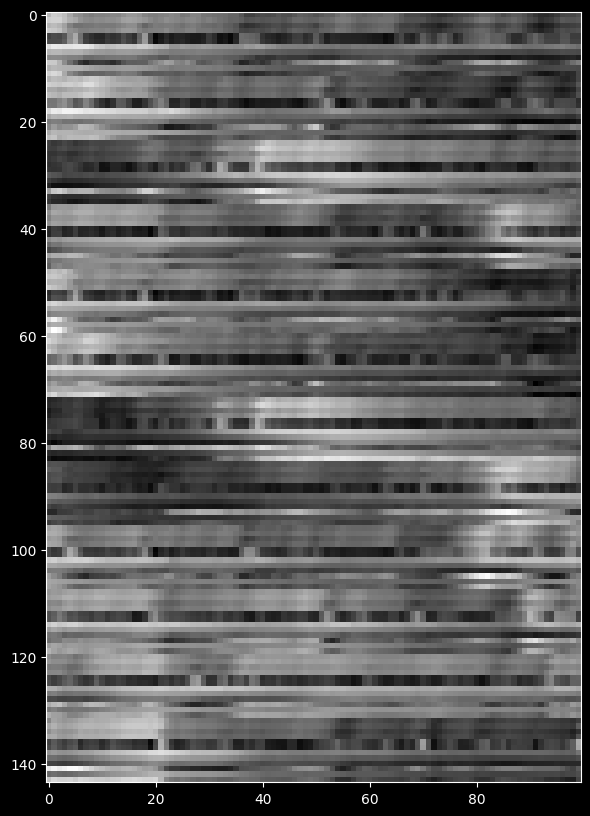

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(decoded[0].transpose(), cmap='gray')

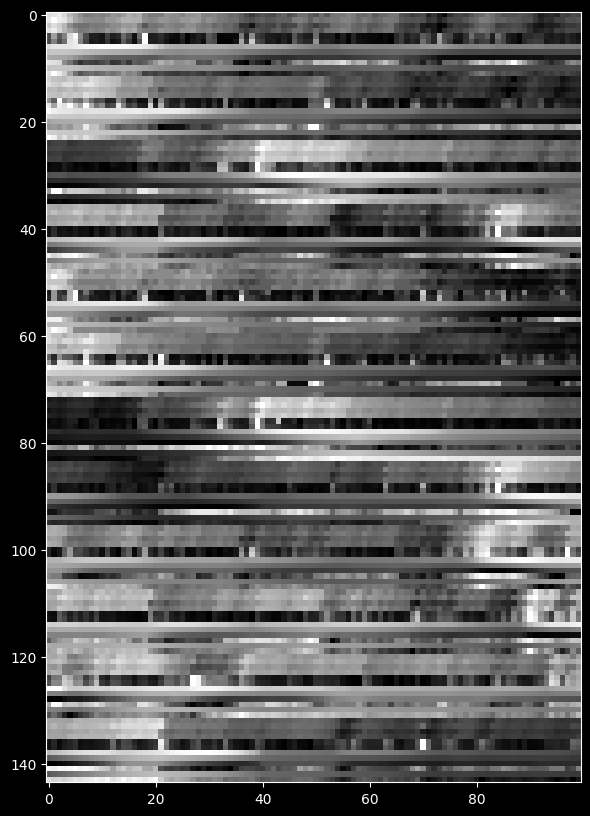

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(test_data[0].transpose(), cmap='gray')